<a href="https://colab.research.google.com/github/annvorosh/GB/blob/main/ML_Med_L02_parkinsons_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ - выполнить классификацию
https://archive.ics.uci.edu/dataset/174/parkinsons
Этот набор данных состоит из ряда биомедицинских голосовых измерений от 31 человека, 23 человека с болезнью Паркинсона (PD).

Каждый столбец в таблице является определенной мерой голоса, и каждая строка соответствует одной из 195 голосовых записей от этих лиц ("имя" столбец).

Основная цель данных заключается в том, чтобы диспрелировать здоровых людей от людей с ПД в соответствии с столбцом "статус", который установлен в 0 для здоровых и 1 для ПД.  

Данные в формате ASCII CSV. Строки CSV-файла содержат экземпляр, соответствующий одной голосовой записи. На каждого пациента около шести записей, имя пациента указано в первой колонке.

### Мы будем решать задачу классификации, чтобы различать здоровых людей и людей с болезнью Паркинсона на основе голосовых измерений.

## Загрузка библиотек

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE

In [3]:
from sklearn.linear_model import LogisticRegression, ElasticNetCV, RidgeCV, LassoCV, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Загрузка данных

In [4]:
!pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
parkinsons = fetch_ucirepo(id=174)

# data (as pandas dataframes)
X = parkinsons.data.features
y = parkinsons.data.targets


In [6]:
# metadata
print(parkinsons.metadata)

# variable information
print(parkinsons.variables)

{'uci_id': 174, 'name': 'Parkinsons', 'repository_url': 'https://archive.ics.uci.edu/dataset/174/parkinsons', 'data_url': 'https://archive.ics.uci.edu/static/public/174/data.csv', 'abstract': "Oxford Parkinson's Disease Detection Dataset", 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 197, 'num_features': 22, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['status'], 'index_col': ['name'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2007, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C59C74', 'creators': ['Max Little'], 'intro_paper': {'title': 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', 'authors': 'Max A. Little, P. McSharry, S. Roberts, D. Costello, I. Moroz', 'published_in': 'BioMedical Engineering OnLine', 'year': 2007, 'url': 'https://www.semanticscholar.org/paper/27e1dcd0d64bfc9d936e597d4f29b8

## Обзор и предобработка данных

In [7]:
X.head()

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00784,0.00370,0.00554,0.01109,0.04374,0.04374,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00968,0.00465,0.00696,0.01394,0.06134,0.06134,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.01050,0.00544,0.00781,0.01633,0.05233,0.05233,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00997,0.00502,0.00698,0.01505,0.05492,0.05492,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.01284,0.00655,0.00908,0.01966,0.06425,0.06425,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


надо будет нормализовать данные

In [8]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   status  195 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MDVP:Fo       195 non-null    float64
 1   MDVP:Fhi      195 non-null    float64
 2   MDVP:Flo      195 non-null    float64
 3   MDVP:Jitter   195 non-null    float64
 4   MDVP:Jitter   195 non-null    float64
 5   MDVP:RAP      195 non-null    float64
 6   MDVP:PPQ      195 non-null    float64
 7   Jitter:DDP    195 non-null    float64
 8   MDVP:Shimmer  195 non-null    float64
 9   MDVP:Shimmer  195 non-null    float64
 10  Shimmer:APQ3  195 non-null    float64
 11  Shimmer:APQ5  195 non-null    float64
 12  MDVP:APQ      195 non-null    float64
 13  Shimmer:DDA   195 non-null    float64
 14  NHR           195 non-null    float64
 15  HNR           195 non-null    float64
 16  RPDE          195 non-null    float64
 17  DFA           195 non-null    float64
 18  spread1       195 non-null    

In [10]:
X.describe()

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.006220,0.003306,0.003446,0.009920,0.029709,0.029709,...,0.024081,0.046993,0.024847,21.885974,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.004848,0.002968,0.002759,0.008903,0.018857,0.018857,...,0.016947,0.030459,0.040418,4.425764,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.001680,0.000680,0.000920,0.002040,0.009540,0.009540,...,0.007190,0.013640,0.000650,8.441000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.003460,0.001660,0.001860,0.004985,0.016505,0.016505,...,0.013080,0.024735,0.005925,19.198000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.004940,0.002500,0.002690,0.007490,0.022970,0.022970,...,0.018260,0.038360,0.011660,22.085000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.007365,0.003835,0.003955,0.011505,0.037885,0.037885,...,0.029400,0.060795,0.025640,25.075500,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.033160,0.021440,0.019580,0.064330,0.119080,0.119080,...,0.137780,0.169420,0.314820,33.047000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [11]:
y.describe()

,status
count,195.000000
mean,0.753846
std,0.431878
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [12]:
X.shape

(195, 22)

наблюдается сильный дисбаланс данных

In [13]:
# Обзор пропусков
X[X.isnull().any(axis=1)]

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE


### Вычисление матрицы корреляции

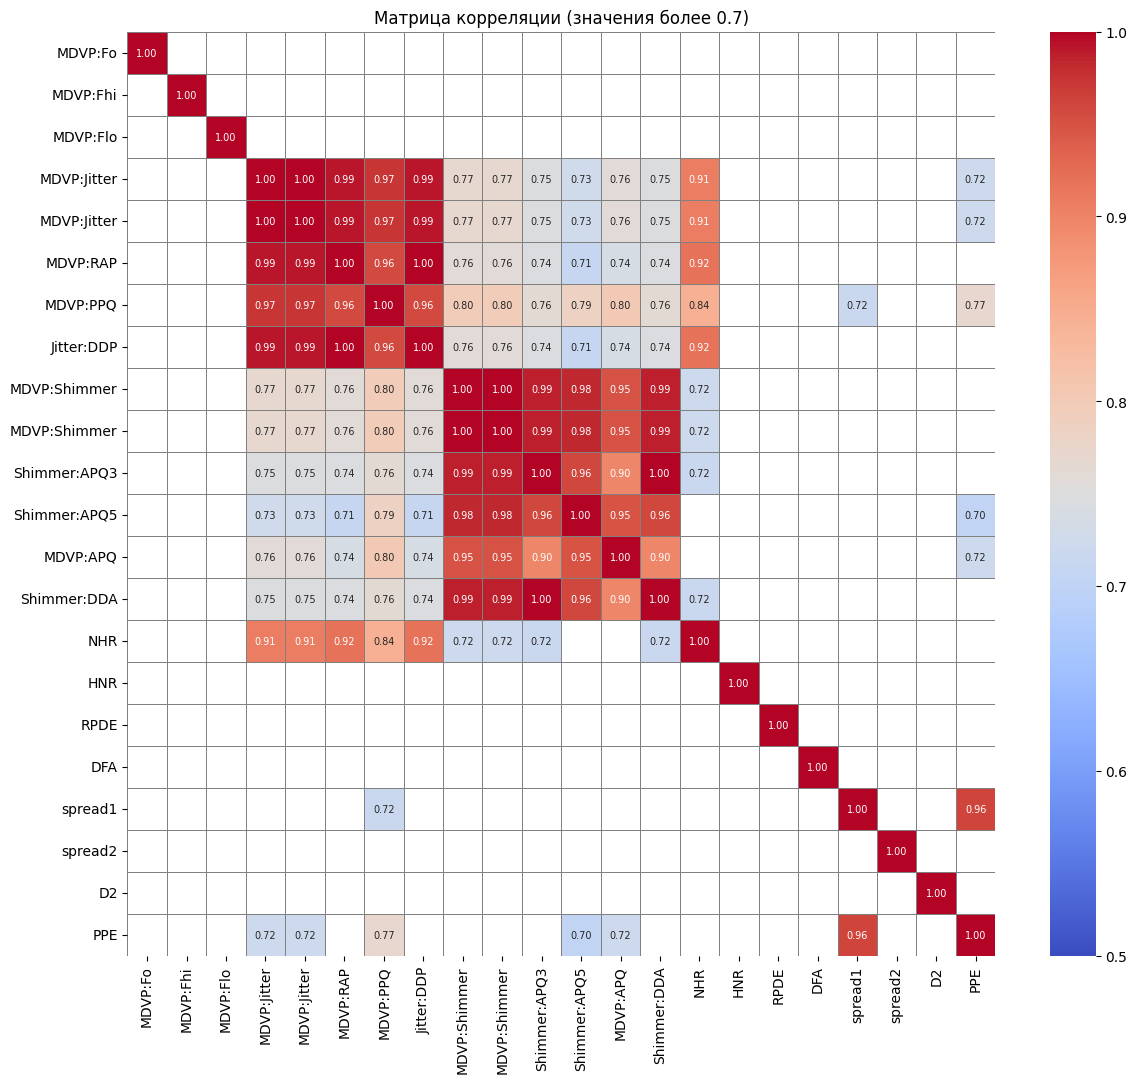

In [14]:
# Вычисление матрицы корреляции
correlation_matrix = X.corr()

# Отфильтровать значения корреляции более 0.7
correlation_matrix_filtered = correlation_matrix.mask(correlation_matrix <= 0.7)

# Создание тепловой карты
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_filtered,annot=True, cmap='coolwarm', fmt=".2f", vmin=0.5, linewidths=0.5, linecolor='gray', annot_kws={"size": 7})
plt.title('Матрица корреляции (значения более 0.7)')
plt.show()

Наиболее сильная корреляция:
Исходя из матрицы корреляции, можно рассмотреть для удаления:

MDVP
Shimmer
RPDE
PPE


In [15]:
X.columns

Index(['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:Jitter', 'MDVP:Jitter',
       'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer',
       'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR',
       'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

### Удаление излишних фичей
Проанализировав матрицу корреляции приняли решение по удалению фичей:

In [16]:
X_drop = X.drop(columns=['MDVP:Jitter', 'MDVP:Jitter',
       'MDVP:RAP', 'MDVP:PPQ', 'MDVP:Shimmer', 'MDVP:Shimmer',
       'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'PPE', 'NHR',
       'spread1'], inplace=True)


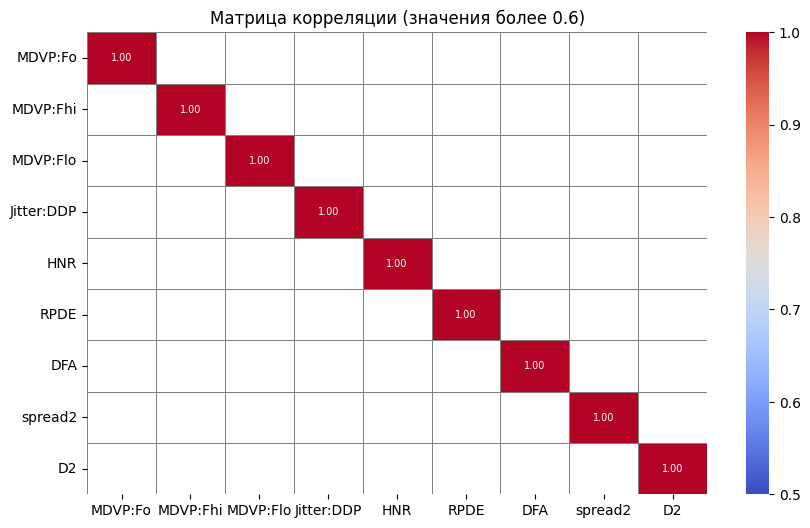

In [18]:
# Вычисление матрицы корреляции
correlation_matrix = X.corr()

# Отфильтровать значения корреляции более 0.6
correlation_matrix_filtered = correlation_matrix.mask(correlation_matrix < 0.6)

# Создание тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_filtered,annot=True, cmap='coolwarm', fmt=".2f", vmin=0.5, linewidths=0.5, linecolor='gray', annot_kws={"size": 7})
plt.title('Матрица корреляции (значения более 0.6)')
plt.show()

### Разделим данные на тест и трейн

In [19]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Устраним дисбаланс данных

In [20]:
y_train.value_counts()

status
1         115
0          41
Name: count, dtype: int64

In [21]:
# Применение SMOTE для генерации новых данных к обучающим данным
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Проверка новых размеров классов
y_train.value_counts()

status
0         115
1         115
Name: count, dtype: int64

## Модели ML

### LogisticRegression

In [22]:
# Логистическая регрессия
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Логистическая регрессия")
print("Точность:", accuracy_log_reg)
print(classification_report(y_test, y_pred_log_reg))

Логистическая регрессия
Точность: 0.7692307692307693
              precision    recall  f1-score   support

           0       0.40      0.57      0.47         7
           1       0.90      0.81      0.85        32

    accuracy                           0.77        39
   macro avg       0.65      0.69      0.66        39
weighted avg       0.81      0.77      0.78        39



### DecisionTreeClassifier

In [23]:
# Модель 2: Дерево решений
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print("\nДерево решений")
print("Точность:", accuracy_tree)
print(classification_report(y_test, y_pred_tree))



Дерево решений
Точность: 0.9230769230769231
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.97      0.94      0.95        32

    accuracy                           0.92        39
   macro avg       0.86      0.90      0.88        39
weighted avg       0.93      0.92      0.93        39



### RandomForestClassifier

In [24]:
# Модель 3: Случайный лес
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
y_pred_forest = forest_clf.predict(X_test)
accuracy_forest = accuracy_score(y_test, y_pred_forest)
print("\nСлучайный лес")
print("Точность:", accuracy_forest)
print(classification_report(y_test, y_pred_forest))


Случайный лес
Точность: 0.9487179487179487
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



### XGBClassifier

In [25]:
# Создайте и обучите XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nXGBClassifier")
print("Точность:", accuracy_xgb)
print(classification_report(y_test, y_pred_xgb))


XGBClassifier
Точность: 0.9743589743589743
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.97      1.00      0.98        32

    accuracy                           0.97        39
   macro avg       0.98      0.93      0.95        39
weighted avg       0.98      0.97      0.97        39



### ВЫВОД

Наилучшая модель: XGBClassifier, с точностью 0.97.

recall для класса 0 составляет 86%, а для класса 1 - 100%. Это означает, что модель хорошо находит все экземпляры класса 1, но не так точна при определении класса 0.

f1-score для класса 0 равна 0.92, а для класса 1 - 0.98. F1-мера является средним гармоническим между точностью и полнотой и представляет собой обобщенную метрику качества классификации.

## Построение кривых обучения для каждой модели

In [26]:
# Функция для построения кривых обучения
def plot_learning_curve(estimator, title, X, y):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, '.-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, '.-', color="b", label="Cross-validation score")

    plt.grid()
    plt.legend(loc="best")
    return plt


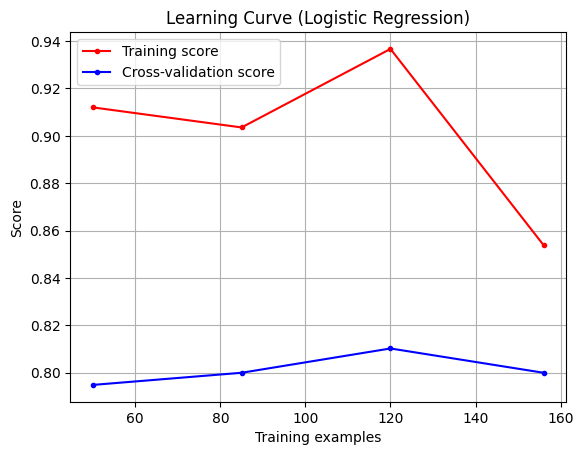

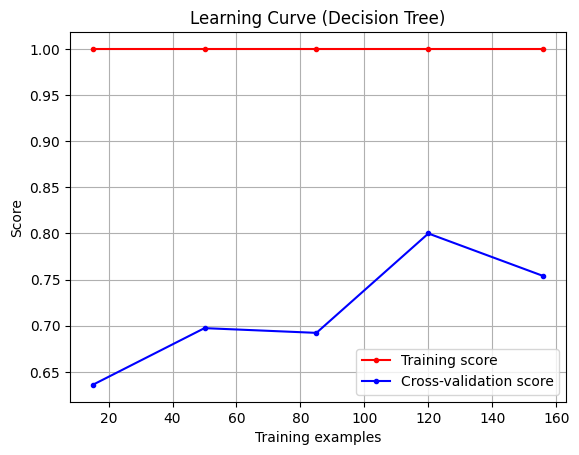

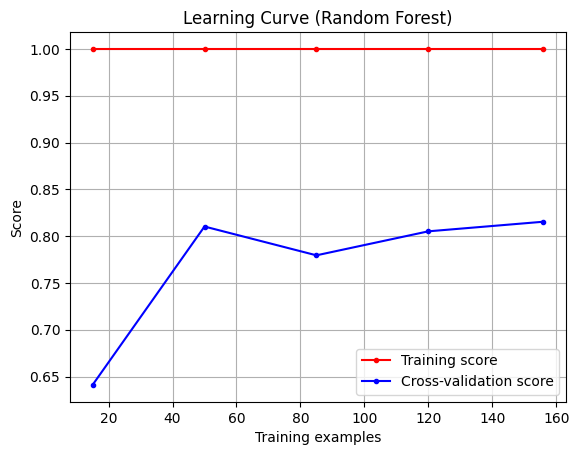

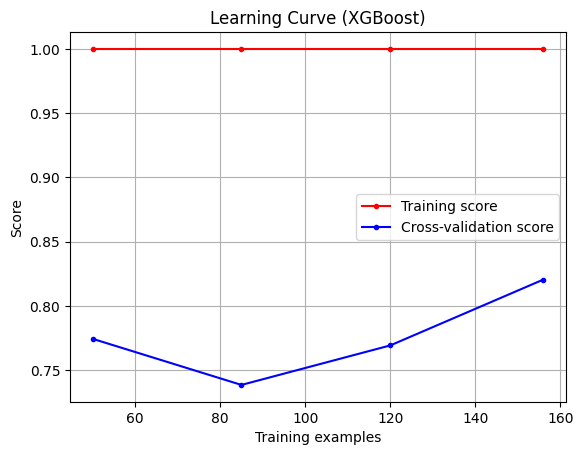

In [27]:
# Модель 1: Логистическая регрессия
plot_learning_curve(LogisticRegression(max_iter=10000), "Learning Curve (Logistic Regression)", X, y)

# Модель 2: Дерево решений
plot_learning_curve(DecisionTreeClassifier(random_state=42), "Learning Curve (Decision Tree)", X, y)

# Модель 3: Случайный лес
plot_learning_curve(RandomForestClassifier(random_state=42), "Learning Curve (Random Forest)", X, y)

# Модель 4: XGBClassifier
plot_learning_curve(XGBClassifier(random_state=42), "Learning Curve (XGBoost)", X, y)

plt.show()


Мы ясно видим, что Training score Decision Tree, Random Forest и XGBoost все еще находится на максимуме, и результат проверки может быть увеличен с помощью большего количества тренировочных образцов.